# Unit 6: Model-based Collaborative Filtering for **Ranking** Prediction

However, we still do Collaborative Filtering and Matrix Factorization in this unit, we do something fundamentally different: we change from rating prediction to **ranking prediction**.

We achieve this by changing the optimization criterion. Instead of minimizing the deviation between true and predicted ratings we push positive and negative user-item combinationa as much as possible apart. We transform explicit user feedback into implicit feedback. Implicit feedback refers to user interaction without the purpose to reflect preference or disregard and is much more common in pactice. Ranking prediction algorithms tackle to learn from implicit feedback data.

In addition, ranking-based algorithms yield a much more intuitive prediction result. Our goal is to present to the user a very limited amount of items in the correct ordering. Therefore, ordering is much more important than rating prediction. Ranking-based algorithms like BPR work pair-wise, i.e. for a user and two items they yield the correct order of both items for the user. Generalizing from this, we can impose an ordering on our item corpus and pick the top-$N$ to present to the user.

In [1]:
from collections import OrderedDict
import itertools
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from recsys_training.data import Dataset
from recsys_training.evaluation import get_relevant_items

In [3]:
ml100k_ratings_filepath = '../../data/raw/ml-100k/u.data'

## Load Data

Different to previous units, we work with implicit feedback data now. However, MovieLens is an explicit feedback dataset, we can argue that everything above the user mean ratings is positive and everything below is negative. Bayesian Personalized Ranking learns from implicit positive feedback data and randomly samples negative feedback data during training. Thus, we keep all ratings above a threhold of $4.0$ and remove all other ratings.

In [4]:
data = Dataset(ml100k_ratings_filepath)
data.filter(min_rating=4.0)
data.rating_split(seed=42)

As we want to learn the user/item latent factors from rating data, we first randomly initialize them

In [30]:
seed = 42
m = data.n_users
n = data.n_items
d = 10

In [31]:
# Latent Factor initialization
random_state = np.random.RandomState(seed)
user_factors = (random_state.rand(m, d) - 0.5) / d
item_factors = (random_state.rand(n, d) - 0.5) / d
        
ratings = data.train_ratings.sample(frac=1, random_state=seed)

In [32]:
# positive implicit feedback items
user_pos_items = {}
# corpus of all remaining items for every user
# Ask me about the "Non missing at random hypothesis" ;)
user_neg_items = {}

In [33]:
grouped = ratings[['user', 'item']].groupby('user')
groups = grouped.groups.keys()
for user in data.users:
    pos_items = []
    if user in groups:
        pos_items = grouped.get_group(user).item.values
    neg_items = np.setdiff1d(data.items, pos_items)
    user_pos_items[user] = pos_items
    user_neg_items[user] = neg_items

## Training

Yes, there is some math involved:

\begin{equation*}
\hat{x}_{uij} = \hat{x}_{ui} - \hat{x}_{uj} \\
x_{ui} = \sum_{f=1}^{d} w_{uf} \cdot h_{if}, i \in I_u^+ \\
x_{uj} = \sum_{f=1}^{d} w_{uf} \cdot h_{jf}, j \in I_u^- \\
\end{equation*}

\begin{equation*}
\text{BPR-Opt} := \sum_{(u,i,j) \in D_S} \ln\sigma(\hat{x}_{uijj}) - \lambda_{\Theta} \cdot ||\Theta||^2
\end{equation*}

\begin{equation*}
\frac{\partial \text{BPR-Opt}}{\partial \Theta} = \frac{-e^{-\hat{x}_{uij}}}{1+e^{-\hat{x}_{uij}}} \cdot \frac{\partial \hat{x}_{uij}}{\partial \Theta} - \lambda_{\Theta} \cdot \Theta
\end{equation*}

\begin{equation*}
\frac{\partial x_{uij}}{\partial \Theta} =
\begin{cases}
(h_{if}-h_{jf}) & \text{for } \Theta = w_{uf} \\
w_{uf} & \text{for } \Theta = h_{if} \\
-w_{uf} & \text{for } \Theta = h_{jf}
\end{cases}
\end{equation*}

Let's talk about regularization!

In [34]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [35]:
def negative_sampling(user: int, user_neg_items: Dict[int, np.array]) -> int:
    """
    Return the item ids for negative samples
    """
    negative_item = np.random.choice(user_neg_items[user])
    
    return negative_item

![](../Parrot.png)

**Task:** Adapt the `compute_gradients` method from the unit before to realize stochastic gradient descent (SGD) for Bayesian Personalized Ranking.

In [36]:
def compute_gradients(user_embed: np.array,
                      pos_item_embed: np.array,
                      neg_item_embed: np.array,
                      l2_decay: Dict[str, float]) -> Tuple[np.array, np.array, np.array]:
    
    pos_pred = np.sum(user_embed * pos_item_embed)
    neg_pred = np.sum(user_embed * neg_item_embed)
    pred = pos_pred - neg_pred

    generic_grad = (-np.exp(-pred) * sigmoid(pred))

    user_grad = generic_grad * (pos_item_embed - neg_item_embed)
    pos_item_grad = generic_grad * user_embed
    neg_item_grad = generic_grad * (-user_embed)

    user_grad += user_embed * l2_decay['user']
    pos_item_grad += pos_item_embed * l2_decay['pos']
    neg_item_grad += neg_item_embed * l2_decay['neg']

    return user_grad, pos_item_grad, neg_item_grad

In [37]:
def print_update(epoch: int, samples: np.array) -> float:
    # take the 1000 most recent ratings and compute the mean ranking loss
    users = samples[:, 0]
    pos_items = samples[:, 1]
    neg_items = np.array([negative_sampling(user, user_neg_items)
                          for user in users])

    user_embeds = user_factors[users - 1]
    pos_item_embeds = item_factors[pos_items - 1]
    neg_item_embeds = item_factors[neg_items - 1]

    pos_preds = np.sum(user_embeds * pos_item_embeds, axis=1)
    neg_preds = np.sum(user_embeds * neg_item_embeds, axis=1)
    preds = pos_preds - neg_preds

    loss = -np.log(sigmoid(preds)).mean()
    
    return loss

Instead of minibatch gradient descent we do **stochastic gradient descent** (SGD) here. It just shrinks the batch size down to 1 instance.

In [38]:
epochs = 30
learning_rate = 0.05
l2_decay = {'user': 0.002, 'pos': 0.0, 'neg': 0.002}
verbose = True

In [39]:
train_ratings_arr = ratings[['user', 'item']].values
test_ratings_arr = data.test_ratings[['user', 'item']].values
n_ratings = len(train_ratings_arr)
train_loss_trace = []
test_loss_trace = []

for epoch in range(epochs):

    for _ in range(len(ratings)):
        random_index = np.random.randint(n_ratings)
        user, pos_item = tuple(train_ratings_arr[random_index])
        neg_item = negative_sampling(user, user_neg_items)

        # Deduct 1 as user ids are 1-indexed, but array is 0-indexed
        user_embed = user_factors[user - 1]
        pos_item_embed = item_factors[pos_item - 1]
        neg_item_embed = item_factors[neg_item - 1]

        user_grad, pos_item_grad, neg_item_grad = \
            compute_gradients(user_embed,
                              pos_item_embed,
                              neg_item_embed,
                              l2_decay)

        user_factors[user - 1] -= learning_rate * user_grad
        item_factors[pos_item - 1] -= learning_rate * pos_item_grad
        item_factors[neg_item - 1] -= learning_rate * neg_item_grad

    if verbose:
        train_samples = train_ratings_arr[-1000:]
        test_samples = test_ratings_arr[-1000:]
        train_loss = print_update(epoch, train_samples)
        test_loss = print_update(epoch, test_samples)
        train_loss_trace.append(train_loss)
        test_loss_trace.append(test_loss)
        print(f"Epoch {epoch+1:02d}: Mean Ranking Loss - Train: {train_loss:.4f}, Mean Ranking Loss - Test: {test_loss:.4f}")

Epoch 01: Mean Ranking Loss - Train: 0.6927, Mean Ranking Loss - Test: 0.6930
Epoch 02: Mean Ranking Loss - Train: 0.6826, Mean Ranking Loss - Test: 0.6845
Epoch 03: Mean Ranking Loss - Train: 0.4907, Mean Ranking Loss - Test: 0.5196
Epoch 04: Mean Ranking Loss - Train: 0.3354, Mean Ranking Loss - Test: 0.3835
Epoch 05: Mean Ranking Loss - Train: 0.3212, Mean Ranking Loss - Test: 0.3557
Epoch 06: Mean Ranking Loss - Train: 0.3095, Mean Ranking Loss - Test: 0.3162
Epoch 07: Mean Ranking Loss - Train: 0.2967, Mean Ranking Loss - Test: 0.3201
Epoch 08: Mean Ranking Loss - Train: 0.2666, Mean Ranking Loss - Test: 0.2891
Epoch 09: Mean Ranking Loss - Train: 0.2796, Mean Ranking Loss - Test: 0.2803
Epoch 10: Mean Ranking Loss - Train: 0.2536, Mean Ranking Loss - Test: 0.2825
Epoch 11: Mean Ranking Loss - Train: 0.2291, Mean Ranking Loss - Test: 0.2704
Epoch 12: Mean Ranking Loss - Train: 0.2004, Mean Ranking Loss - Test: 0.2659
Epoch 13: Mean Ranking Loss - Train: 0.2220, Mean Ranking Loss -

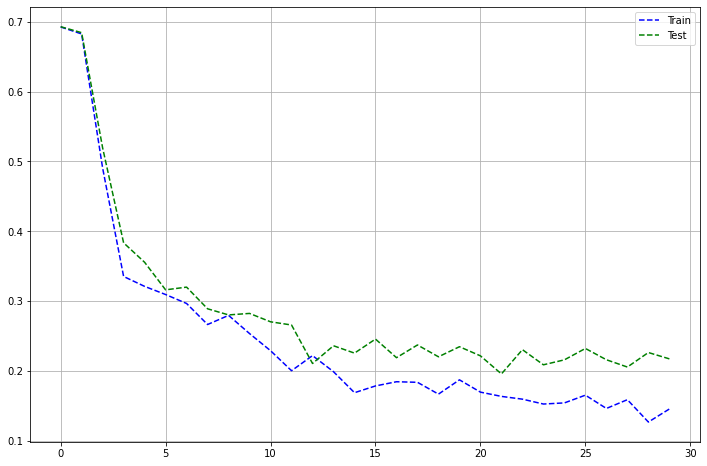

In [40]:
plt.figure(figsize=(12,8))
plt.plot(range(epochs), train_loss_trace, 'b--', label='Train')
plt.plot(range(epochs), test_loss_trace, 'g--', label='Test')
plt.grid(True)
plt.legend()
plt.show()

### Using the model for Recommendations

We have now created a model to describe users and items in terms of latent vectors. But this time we fitted them to get the rankings correctly. So for obtaining recommendations we simply multiply user-item latent vectors we are interested in and achieve an estimate that can be used to order items for a given user. This time it is not a rating prediction, but still a prediction.

For that, we can reuse the `get_prediction` method from previous units.

Thus, before writing the `get_recommendations` again we first implement `get_prediction`.

In [41]:
def get_prediction(user: int, items: np.array = None, remove_known_pos: bool = True) -> Dict[int, Dict[str, float]]:
    if items is None:
        if remove_known_pos:
            # Predict from unobserved items
            # We simplified this compared to the unit before
            items = user_neg_items[user]
        else:
            items = np.array(data.items)
    if type(items) == np.int64:
        items = np.array([items])
    
    user_embed = user_factors[user - 1].reshape(1, -1)
    item_embeds = item_factors[items - 1].reshape(len(items), -1)

    # use array-broadcasting
    preds = np.sum(user_embed * item_embeds, axis=1)
    sorting = np.argsort(preds)[::-1]
    preds = {item: {'pred': pred} for item, pred in
             zip(items[sorting], preds[sorting])}

    return preds

In [42]:
item_predictions = get_prediction(1)

In [43]:
list(item_predictions.items())[:20]

[(7, {'pred': 6.7165212822527804}),
 (475, {'pred': 6.190053386749307}),
 (98, {'pred': 5.925275881769105}),
 (179, {'pred': 5.039790962508783}),
 (204, {'pred': 5.021097232110073}),
 (96, {'pred': 4.979480595381881}),
 (109, {'pred': 4.9214734048628115}),
 (135, {'pred': 4.828672637052316}),
 (24, {'pred': 4.8243917910300915}),
 (183, {'pred': 4.733611429979362}),
 (8, {'pred': 4.716514643503111}),
 (180, {'pred': 4.715562448197086}),
 (514, {'pred': 4.689218154484445}),
 (258, {'pred': 4.650940982830324}),
 (208, {'pred': 4.6125552312614895}),
 (70, {'pred': 4.588018992040444}),
 (210, {'pred': 4.517376233935581}),
 (474, {'pred': 4.516616396539871}),
 (531, {'pred': 4.474738453600442}),
 (428, {'pred': 4.469018198854879})]

In [44]:
def get_recommendations(user: int, N: int, remove_known_pos: bool = False) -> List[Tuple[int, Dict[str, float]]]:
    predictions = get_prediction(user, remove_known_pos=remove_known_pos)
    recommendations = []
    for item, pred in predictions.items():
        add_item = (item, pred)
        recommendations.append(add_item)
        if len(recommendations) == N:
            break

    return recommendations

In [45]:
recommendations = get_recommendations(1, 10)

In [46]:
recommendations

[(7, {'pred': 6.7165212822527804}),
 (50, {'pred': 6.5449830328877505}),
 (56, {'pred': 6.453679549462952}),
 (238, {'pred': 6.2038273244964355}),
 (475, {'pred': 6.190053386749307}),
 (181, {'pred': 6.189498776345734}),
 (174, {'pred': 6.109045602294025}),
 (100, {'pred': 5.972914912203246}),
 (98, {'pred': 5.925275881769105}),
 (172, {'pred': 5.918597569439271})]

## Evaluation

In [47]:
N = 10

In [48]:
relevant_items = get_relevant_items(data.test_ratings)

In [49]:
users = relevant_items.keys()
prec_at_N = dict.fromkeys(data.users)

for user in users:
    recommendations = get_recommendations(user, N, remove_known_pos=True)
    recommendations = [val[0] for val in recommendations]
    hits = np.intersect1d(recommendations,
                          relevant_items[user])
    prec_at_N[user] = len(hits)/N

In [50]:
recommendations

[7, 121, 410, 174, 144, 265, 195, 1, 204, 550]

In [51]:
np.mean([val for val in prec_at_N.values() if val is not None])

0.18762214983713357